In [1]:
# Libraries
from collections import defaultdict
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn.apionly as sns

def getfisher(R, TISSUES):
    O=defaultdict(list)
    Mapdata = {}
    for tis in TISSUES:

        field= 'eSTR.'+SHORTEN[tis]

        # Focus on estrs and motifs
        data = R[["gene","chrom", "str.start","motif",field]]#,"best.score","best.tissue","INTRON"]]
        data_e = data.loc[data[field]>0]
        #
        #frequent_motifs estrs
        Motifs = list(set(list(data_e['motif'])))
        Mo_counts=[list(data['motif']).count(x) for x in Motifs]
        Estr = data_e.shape[0]
        Str = data.shape[0]
        All = []
        # Fisher test for each motif
        for M in Motifs:
            data_eM = data_e.loc[data_e['motif']==M]
            data_M = data.loc[data['motif']==M]
            Mestrs = data_eM.shape[0]
            Mstrs = data_M.shape[0]
            CTT = [[Mestrs, Estr - Mestrs] , [Mstrs-Mestrs , Str-Estr -(Mstrs - Mestrs)]] #contengency
            oddsratio, pv = ss.fisher_exact([CTT[0], CTT[1]])                             #Fisher
            #print ("P (", M, ")    ~~   ",pv*100,"%     with    OR=", oddsratio)
        #
            All.append([M,list(data_e['motif']).count(M),-np.log10(pv),oddsratio])
            O[M].append(oddsratio)
        #
        Mapdata[tis]=All
    # Selecting motifs present in all tissues
    Mset = []
    for o in O.keys():      # O has all the motifs and occurence in tissues
        if len(O[o])>=len(TISSUES):
            Mset.append(o)
    print(len(Mset))
    #heatmap matix
    pdata = np.zeros((len(TISSUES), len(Mset)))
    for i in range(len(TISSUES)):
        T = TISSUES[i]
        for j in range(len(Mset)):
            m=Mset[j]
            val = [s[3] for s in  Mapdata[T] if s[0]==m ]
            if val==[]:
                pdata[i][j] =0
            else:
                pdata[i][j] =val[0]
    return Mset, O,Mapdata, pdata


SHORTEN = {
    "Artery-Aorta":"Artery.A"     ,
    "Artery-Tibial": "Artery.T",
    "Adipose-Subcutaneous": "Adipose.S",    
    "Adipose-Visceral(Omentum)":"Adipose.V",
    "Brain-Caudate(basalganglia)":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "Mucosa",
    "Esophagus-Muscularis":"Muscularis",
    "Heart-LeftVentricle":"Ventricule",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed(Suprapubic)": "SkinUnexposed",
    "Skin-SunExposed(Lowerleg)":"SkinLeg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood"
}

TISSUES = [item for item in list(SHORTEN.keys())]
regr='/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
feat='/storage/szfeupe/Runs/GTEx_estr/FEATURES/Allgencodefeatures_table'
motif='/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif.bed'
strand= '/storage/resources/dbase/human/hg19/hg19.hipstr_reference_withmotif_stranded.bed'



In [2]:
G = pd.read_csv(regr, sep='\t')  ; 
X = G.loc[G['period']==1][["gene","chrom","str.start","E.tissues"]]
print(G.shape, X.shape)
for i in range(7):
    print ('Number of eSTRs share by ', i, " tissues or more is :\t", X.loc[X['E.tissues']>i].shape[0])
"""
Number of eSTRs share by  1  tissues or more is :	 5783
Number of eSTRs share by  2  tissues or more is :	 1523
"""
#G.loc[G['gene']=="ENSG00000160213.5"][["gene","chrom","str.start",'eSTR.Cerebellum', "E.tissues","motif", "str.end"]] #.transpose()

(98671, 94) (35951, 4)
Number of eSTRs share by  0  tissues or more is :	 3416
Number of eSTRs share by  1  tissues or more is :	 1327
Number of eSTRs share by  2  tissues or more is :	 777
Number of eSTRs share by  3  tissues or more is :	 530
Number of eSTRs share by  4  tissues or more is :	 396
Number of eSTRs share by  5  tissues or more is :	 317
Number of eSTRs share by  6  tissues or more is :	 246


'\nNumber of eSTRs share by  1  tissues or more is :\t 5783\nNumber of eSTRs share by  2  tissues or more is :\t 1523\n'

In [2]:
#open files
FT = pd.read_csv(feat, sep='\t')
#Only work with STR in gene boundary
G = pd.read_csv(regr, sep='\t')  ; X = G[["gene","chrom","str.start","E.tissues"]]
print(G.shape)
FTGene = FT.loc[FT['feature.type']=='gene']
#intersect
Reg = G[['chrom','str.start','str.end','gene','str.id']]; Reg.to_csv('reg.bed', sep='\t',index=None, header=None)
Genes = FTGene[['chrom','start','stop']]; Genes.to_csv('genes.bed', sep='\t',index=None, header=None)
print(Reg.shape, Genes.shape)
cmd = "bedtools intersect -a reg.bed -b genes.bed -wb -names Gene >Intersect.bed"
returned_value = os.system(cmd)
print('Done')
inner = pd.read_csv('Intersect.bed', sep='\t', header=None)
inner.columns=['chrom','str.start','str.end','gene','str.id','chrom_x','gene.start','gene.end']
print(inner.shape)
data = pd.merge(inner[['chrom','str.start','str.end','gene','str.id']], G, on =['chrom','str.start','str.id','gene','str.end'])
data.shape

(38365, 59)
(38365, 5) (57820, 3)
Done
(28997, 8)


(28926, 59)

In [3]:
G = data

In [4]:
S = pd.read_csv(strand, sep='\t', header=None)
S.columns =['chrom','str.start','end','motiflength', 'For_motif','Rev_motif']
G = pd.merge(G, S[['chrom','str.start','For_motif','Rev_motif']], on=['chrom','str.start'], how='inner')
print(G.shape)
#
A = pd.read_csv('/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv', sep=',')
A['gene']=A['gene.id'];                 A['chrom'] = A['gene.chr']
GG = pd.merge(G, A[['chrom','gene', 'gene.strand']], on=['chrom','gene'])
print(GG.shape)
Mset,O,Mapdata,pdata = getfisher(GG,TISSUES)
#clustered heatmap by correlation
df1 = pd.DataFrame(pdata)
df1.index = [SHORTEN[t] for t in TISSUES]
df1.columns = Mset

(28926, 61)
(28926, 62)
(28926, 63)
positive strands
15
(14680, 63) 15
negative strands
14
(14246, 63) 14


/usr/lib64/python3.4/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


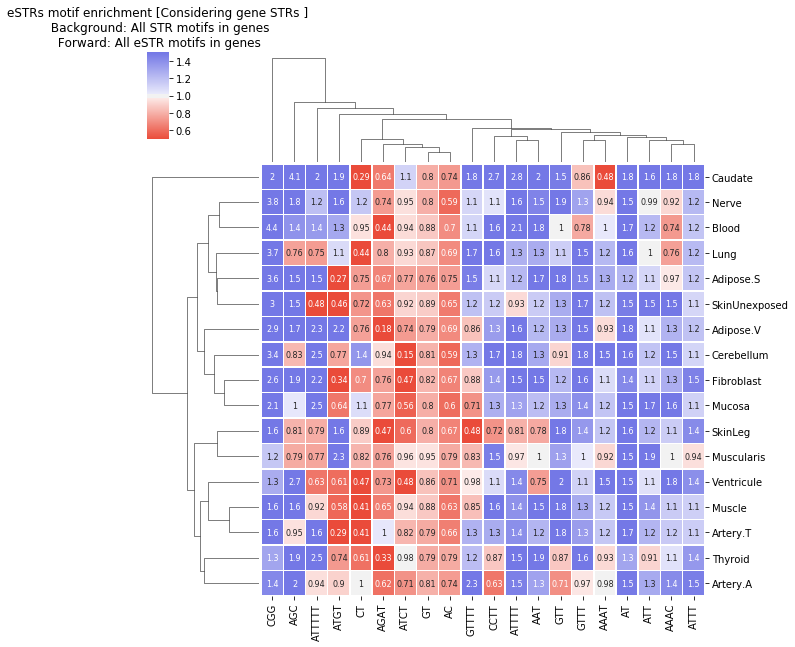

In [6]:
'''
metric="correlation"
Witout metric, the cluster is based on the pairwise euclidean distances between observation
'''
#plot Enrichrment by strands

cmap = sns.diverging_palette(15, 265, s=80, l=55, n=9, as_cmap=True)    
g = sns.clustermap(df1, cmap=cmap, annot=True, annot_kws={"size": 8},
            vmin=0.5, vmax=1.5, linewidths=0.5   );
ax = g.ax_heatmap
plt.setp(ax.get_yticklabels(), rotation=0)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('eSTRs motif enrichment [Considering gene STRs ]\n Background: All STR motifs in genes\n Forward: All eSTR motifs in genes')
plt.show()